## Problem Statement
#### Create a classifier to tell whether a SMS message is spam or ham

ML Framework: Scikit-learn
Algorithm: Decision Tree

##### Why this frame-work and model is choose?
The KISS principle in machine learning - Simple solutions are to be preferred, while unnecessary complexity should be avoided. In machine learning its good to start with simple models, if required/neccessary we can work upwards towards complicated ones.

Models used:
+ Non-Linear alorithm: Decision Tree
+ Naive algorithm: Naive Bayes
+ Ensemble algorithm: Balanced Bagging Classifier

In [1]:
# Import required modules

import os
import nltk
import platform
import chardet
import pickle
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

### Data Setup
Creating dataset for processing

In [2]:
# Initialize system dir path

system_env = platform.system().lower()
if system_env == 'linux':
    BASE_DIR = '/tmp/nlp_spam_ham'
else:
    BASE_DIR = 'C:\nlp_spam_ham'

os.makedirs(BASE_DIR, mode=0o777, exist_ok=True)

In [3]:
# Change directory and download the dataset

os.chdir(BASE_DIR)
!wget https://rizcodes-aiml.s3.us-east-2.amazonaws.com/public/spam.csv
os.listdir()

--2021-01-24 21:30:19--  https://rizcodes-aiml.s3.us-east-2.amazonaws.com/public/spam.csv
Resolving rizcodes-aiml.s3.us-east-2.amazonaws.com (rizcodes-aiml.s3.us-east-2.amazonaws.com)... 52.219.100.232
Connecting to rizcodes-aiml.s3.us-east-2.amazonaws.com (rizcodes-aiml.s3.us-east-2.amazonaws.com)|52.219.100.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K   527KB/s    in 0.9s    

2021-01-24 21:30:21 (527 KB/s) - ‘spam.csv’ saved [503663/503663]



['spam.csv']

In [4]:
# Read dataset as DataFrame

DATA_CSV = os.path.join(BASE_DIR, 'spam.csv')

# Detect Character encoding
with open(DATA_CSV, 'rb') as f:
    char_encoding = chardet.detect(f.read(100000))
print (char_encoding)

# Create DataFrame
df = pd.read_csv(DATA_CSV, encoding=char_encoding.get('encoding'))
df.head()

{'encoding': 'Windows-1252', 'confidence': 0.7270322499829184, 'language': ''}


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Clean the Data

df.dropna(axis='columns', inplace=True)
df.columns = ["label", "data"]
df.head()

,label,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Encode the labels

df.replace({'label': {'ham': 0, 'spam': 1}}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   data    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


Num of ham samples: 4825
Num of spam samples: 747


array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

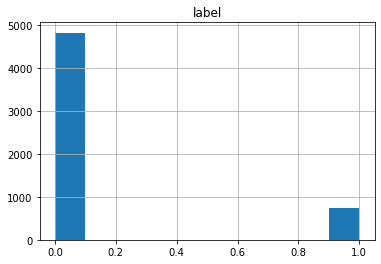

In [7]:
num_ham = df[df.label == 0].data.count()
num_spam = df[df.label == 1].data.count()
print (f'Num of ham samples: {num_ham}\nNum of spam samples: {num_spam}')
df.hist()

### Text Processing
Cleaning and text processing
+ Eliminate unnecessary characters
+ Tokenize
+ Normalization - Stemming

In [8]:
# Download nltk libraries

nltk.download()
from nltk.corpus import brown
brown.words()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [9]:
# Normalize the message data

# Get messages
messages = df.data.to_list()
# Tokenizer and remove all special charaters
tokenizer = RegexpTokenizer(r'\w+')
# Stemmer
stemmer = PorterStemmer()
# Get stopwords
stop_words = set(stopwords.words('english'))


def normalize_text(msg):
    norm_msg = []
    sentence = tokenizer.tokenize(msg)
    for word in sentence:
        if (word in stop_words) or (word.isspace()) or (word==''):
            continue
        s_word = stemmer.stem(word)
        norm_msg.append(s_word)
    return " ".join(norm_msg)

final_data = [normalize_text(msg) for msg in messages]

In [10]:
# Update the normalized data into DataFrame

df['messages'] = final_data
df.drop(columns=['data'], inplace=True)
df.head()

,label,messages
0,0,Go jurong point crazi avail bugi n great world...
1,0,Ok lar joke wif u oni
2,1,free entri 2 wkli comp win FA cup final tkt 21...
3,0,U dun say earli hor U c alreadi say
4,0,nah I think goe usf live around though


### Deploy Machine learning models
+ Decision tree
+ Naive Bayes
+ Balanced bagging classifier

In [11]:
# Splitting Train and Test data

X = df.messages
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train.shape, X_test.shape

((4736,), (836,))

In [12]:
# Vectorize the features

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

train_vectors.shape, test_vectors.shape

((4736, 6728), (836, 6728))

In [13]:
# ML non-linear algorithm - DecisionTree

# Train data
model_dt = DecisionTreeClassifier()
model_dt.fit(train_vectors, y_train)

# Predict test data
y_pred_dt = model_dt.predict(test_vectors)

# Model metrics
model_accuracy_score_dt = model_dt.score(test_vectors, y_test)
print (f'Decision Tree Accuracy: {model_accuracy_score_dt * 100}')
print (f'\nPrecision-Recall-F1_Score:\n{classification_report(y_test,y_pred_dt)}')
print (f'\nConfusion matrix:\n {confusion_matrix(y_test,y_pred_dt)}')

Decision Tree Accuracy: 97.36842105263158

Precision-Recall-F1_Score:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       728
           1       0.91      0.88      0.90       108

    accuracy                           0.97       836
   macro avg       0.95      0.93      0.94       836
weighted avg       0.97      0.97      0.97       836


Confusion matrix:
 [[719   9]
 [ 13  95]]


In [14]:
# ML naive algorithm - Naive Bayes

# Train data
model_nb = MultinomialNB()
model_nb.fit(train_vectors, y_train)

# Predict test data
y_pred_nb = model_nb.predict(test_vectors)

# Model metrics
model_accuracy_score_nb = model_nb.score(test_vectors, y_test)
print (f'Naive Bayes Accuracy: {model_accuracy_score_nb * 100}')
print (f'\nPrecision-Recall-F1_Score:\n{classification_report(y_test,y_pred_nb)}')
print (f'\nConfusion matrix:\n {confusion_matrix(y_test,y_pred_nb)}')

Naive Bayes Accuracy: 97.24880382775119

Precision-Recall-F1_Score:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       728
           1       1.00      0.79      0.88       108

    accuracy                           0.97       836
   macro avg       0.98      0.89      0.93       836
weighted avg       0.97      0.97      0.97       836


Confusion matrix:
 [[728   0]
 [ 23  85]]


In [15]:
# Imbalanced dataset handling - BalancedBagging using DT (Ensemble)

model_bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                      sampling_strategy='auto',
                                      replacement=False,
                                      random_state=0)
model_bbc.fit(train_vectors, y_train)
y_pred_bbc = model_bbc.predict(test_vectors)

# Model metrics
model_accuracy_score_bbc = model_bbc.score(test_vectors, y_test)
print (f'BalancedBaggingClassifier Accuracy: {model_accuracy_score_bbc * 100}')
print (f'\nPrecision-Recall-F1_Score:\n{classification_report(y_test,y_pred_bbc)}')
print (f'\nConfusion matrix:\n {confusion_matrix(y_test,y_pred_bbc)}')

BalancedBaggingClassifier Accuracy: 94.97607655502392

Precision-Recall-F1_Score:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       728
           1       0.76      0.89      0.82       108

    accuracy                           0.95       836
   macro avg       0.87      0.92      0.90       836
weighted avg       0.95      0.95      0.95       836


Confusion matrix:
 [[698  30]
 [ 12  96]]


### Conclusion:
+ Though all models have good accuray, after observing the f1-score
+ Decision-Tree classifier has better metrics compared to other two
+ Naive-bayes: Sufferred recall due to its more false-negatives
+ BalanceBaggingClassifier: Suffered precision due to its more false-positives

In [16]:
# Test the data with the trained model
model = model_dt

def decode_label(num):
    """Returns the message label value as string
    """
    if num == 1:
        return 'spam'
    return 'ham'

def predict_message(raw_data):
    """Classifies the incoming message as either 'ham' or 'spam'
    """
    raw_input = {'data': [raw_data]}
    df_input = pd.DataFrame(raw_input)
    data_input = df_input.data
    feature_vector = vectorizer.transform(data_input)
    predicted_label = model.predict(feature_vector)
    
    return decode_label(int(predicted_label[0]))

In [17]:
# Test a random message
i = np.random.randint(500)
input_data = X_test.iloc[i]
y_hat = predict_message(input_data)
print(f'Test Message: {input_data}\nPrediction: {y_hat}\nExpected: {decode_label(y_test.iloc[i])}')

Test Message: you won guarante å 1000 cash å 2000 prize To claim yr prize call custom servic repres
Prediction: spam
Expected: spam


In [18]:
# Save the model and vectorizer

model_file_name = 'dt_model.pkl'
tfidf_file_name = 'tfidf.pkl'
pickle.dump(model, open(model_file_name, 'wb'))
pickle.dump(vectorizer, open(tfidf_file_name, 'wb'))

In [19]:
# Load the model from file

# loaded_model = pickle.load(open(filename, 'rb'))

# 